In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas
import sys
import time
import itertools
import subprocess

from cpuinfo import get_cpu_info
from matplotlib.ticker import MultipleLocator
from scipy.stats import chi2
from itertools import product
from sklearn import preprocessing, naive_bayes
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score

sys.path.append('C:\\ADSP\\ADSP31017\\Code')
import LogisticRegression
import ModelAssessment

# Set some options for printing all the columns
numpy.set_printoptions(precision = 10, threshold = sys.maxsize)
numpy.set_printoptions(linewidth = numpy.inf)

pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)

pandas.options.display.float_format = '{:,.7f}'.format

In [3]:
whas500 = pandas.read_csv("/Users/olivia/Downloads/ML - Assignment 1/whas500_final.csv")

# Convert dates
whas500[['admitdate', 'disdate', 'fdate']] = whas500[['admitdate', 'disdate', 'fdate']].apply(pandas.to_datetime, dayfirst=True)

# Map the lenfol
bins = [-float("inf"), 30, 180, 540, float("inf")]
labels = ["≤30 days", "31-180 days", "181-540 days", ">540 days"]
whas500["lenfol_category"] = pandas.cut(whas500["lenfol"], bins=bins, labels=labels, right=True)

# Define categorical and continuous predictors
cat_pred = ['afb', 'av3', 'chf', 'cvd', 'gender', 'miord', 'mitype', 'sho']
int_pred = ['age', 'bmi', 'diasbp', 'hr', 'sysbp']

# Binning continuous predictors
bin_edges = {
    'age': [67.5, 72.5, 85.5],
    'bmi': [23.2982, 24.2238, 28.5612],
    'diasbp': [60.5, 76.5, 97.5],
    'hr': [67.5, 83.5, 102.5],
    'sysbp': [106.5, 136.5, 185.0]
}

for var, edges in bin_edges.items():
    whas500[var + '_bin'] = pandas.cut(whas500[var], bins=[-float("inf")] + edges + [float("inf")], labels=[0, 1, 2, 3])


In [4]:
# Define features and target
feature = cat_pred + [var + '_bin' for var in int_pred]
target = 'lenfol_category'

# Prepare dataset
train_data = whas500[feature + [target]].dropna().reset_index(drop=True)

# Retrieve the target's categories
count_target = train_data[target].value_counts().sort_index()
category_target = list(count_target.index)

# Encode categorical features
category_features = [train_data[f].astype('category').cat.categories.tolist() for f in feature]
feature_encoder = OrdinalEncoder(categories=category_features)
X_train = feature_encoder.fit_transform(train_data[feature])
y_train = train_data[target].astype('category')

# Generate all feature subsets
num_features = len(feature)
all_subsets = list(itertools.chain.from_iterable(itertools.combinations(feature, r) for r in range(1, num_features + 1)))

# Train Naïve Bayes models for all subsets
model_results = []
start_time = time.time()

for subset in all_subsets:
    subset_features = list(subset)
    subset_encoder = OrdinalEncoder(categories=[category_features[feature.index(f)] for f in subset_features])
    X_subset = subset_encoder.fit_transform(train_data[subset_features])
    
    model = CategoricalNB(alpha=0)
    model.fit(X_subset, y_train)
    
    y_pred_prob = model.predict_proba(X_subset)
    y_pred = model.predict(X_subset)

    # Compute metrics using ModelAssessment functions
    y_train_str = y_train.astype(str)  # Convert y_train to string to match expected input
    pred_prob_df = pandas.DataFrame(y_pred_prob, columns=['P_' + str(c) for c in y_train_str.unique()])
    metrics = ModelAssessment.nominal_model_metric(y_train_str, pred_prob_df)
    
    # Compute metrics using ModelAssessment functions
    xtab = pandas.crosstab(pandas.Series(y_pred_prob.argmax(axis=1)), y_train)
    #metrics = ModelAssessment.nominal_model_metric(y_train, pandas.DataFrame(y_pred_prob, columns=['P_' + str(c) for c in y_train.cat.categories]))
    
    model_results.append({
        'num_features': len(subset_features),
        'features': subset_features,
        'accuracy': 1 - metrics['MCE'],
        'RASE': metrics['RASE'],
        'AUC': metrics['AUC']
    })

# Execution time
end_time = time.time()
total_time = end_time - start_time

In [5]:
model_results_df = pandas.DataFrame(model_results)
print(f"Total model trained is {len(model_results)}")
print(model_results_df)

Total model trained is 8191
      num_features                                                                                           features  accuracy      RASE       AUC
0                1                                                                                              [afb] 0.1140000 0.4823868 0.4825450
1                1                                                                                              [av3] 0.1140000 0.4820938 0.4959364
2                1                                                                                              [chf] 0.1140000 0.4887263 0.4984022
3                1                                                                                              [cvd] 0.1140000 0.4819765 0.4964632
4                1                                                                                           [gender] 0.1140000 0.4819232 0.4908500
...            ...                                                                  

In [6]:
print(f"Total Time for Trained Model: {total_time}")

Total Time for Trained Model: 37908.45240187645


In [7]:
def get_cpu_speed():
    try:
        cpu_info = subprocess.check_output("sysctl -n machdep.cpu.brand_string", shell=True).decode().strip()
        if "Apple M1" in cpu_info:
            return "Apple M1 ~3.2 GHz"  # Approximate known speed
        return cpu_info
    except Exception:
        return "Could not retrieve CPU speed"

cpu_speed = get_cpu_speed()
print(f"CPU Clock Speed: {cpu_speed}")

CPU Clock Speed: Apple M1 ~3.2 GHz


Text(0.5, 1.0, 'Accuracy vs. Number of Predictors')

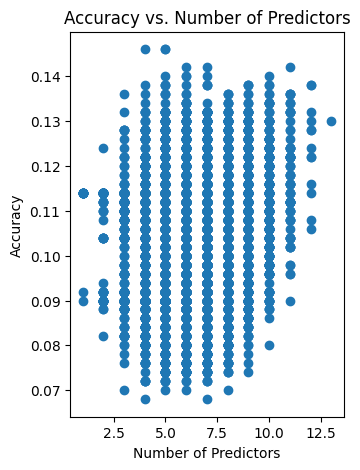

In [8]:
# Plot Accuracy, RASE, AUC
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(model_results_df['num_features'], model_results_df['accuracy'])
plt.xlabel("Number of Predictors")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Predictors")

In [9]:
model_results_df

,num_features,features,accuracy,RASE,AUC
0,1,[afb],0.1140000,0.4823868,0.4825450
1,1,[av3],0.1140000,0.4820938,0.4959364
2,1,[chf],0.1140000,0.4887263,0.4984022
3,1,[cvd],0.1140000,0.4819765,0.4964632
4,1,[gender],0.1140000,0.4819232,0.4908500
...,...,...,...,...,...
8186,12,"[afb, av3, chf, gender, miord, mitype, sho, age_bin, bmi_bin, diasbp_bin, hr_bin, sysbp_bin]",0.1320000,0.5328192,0.4463292
8187,12,"[afb, av3, cvd, gender, miord, mitype, sho, age_bin, bmi_bin, diasbp_bin, hr_bin, sysbp_bin]",0.1060000,0.5283889,0.4381577
8188,12,"[afb, chf, cvd, gender, miord, mitype, sho, age_bin, bmi_bin, diasbp_bin, hr_bin, sysbp_bin]",0.1280000,0.5330163,0.4453879
8189,12,"[av3, chf, cvd, gender, miord, mitype, sho, age_bin, bmi_bin, diasbp_bin, hr_bin, sysbp_bin]",0.1280000,0.5326483,0.4454991
